# Processing sequences using RNNs and CNNs

This notebook reproduces the results we see in Chapter 15 in the textbook. For more execises from the book, see the authors' GitHub repository: https://github.com/ageron/handson-ml3/ Here you will find the solutions to the exercises below,
so don't look before you tried solving them yourself :)

Some comments and changes have been added to Geron's original notebook, just for clarity.


## Setup

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

Matplotlib settings to adjust the figures.

In [2]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

A function to save images to `images/rnn`.

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Basic RNNs

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

In [14]:
filepath = tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)
if "_extracted" in filepath:
    ridership_path = Path(filepath) / "ridership"
else:
    ridership_path = Path(filepath).with_name("ridership")

Check that the file exists:

In [15]:
!ls datasets/ridership_extracted/ridership/

CTA_-_Ridership_-_Daily_Boarding_Totals.csv


For convenience we use the Pandas library to read the CSV file and do some minor data manipulation.

In [16]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership_extracted/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [17]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

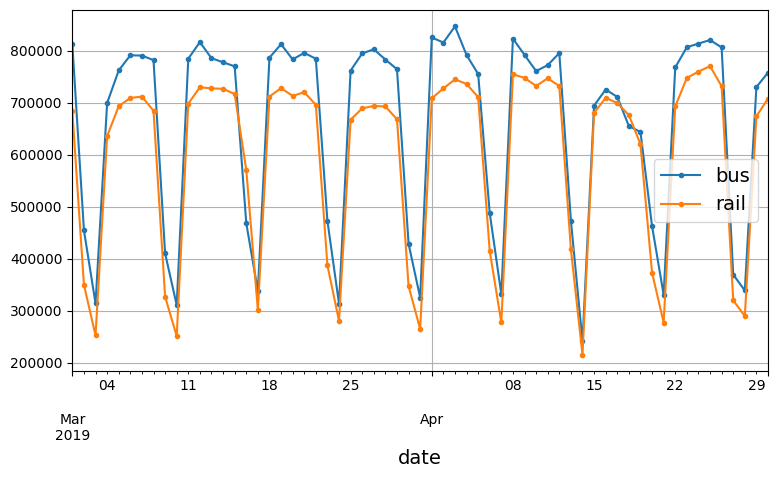

In [18]:
df["2019-03":"2019-04"].plot(grid=True, marker=".", figsize=(8, 5))
save_fig("daily_ridership_plot")  # extra code – saves the figure for the book
plt.show()

Now, let's look at the difference between each time step and the same dat last week. We can compute this by using the [`diff`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html) function.

Does it look like there is always the same number of travellers each Tuesday?

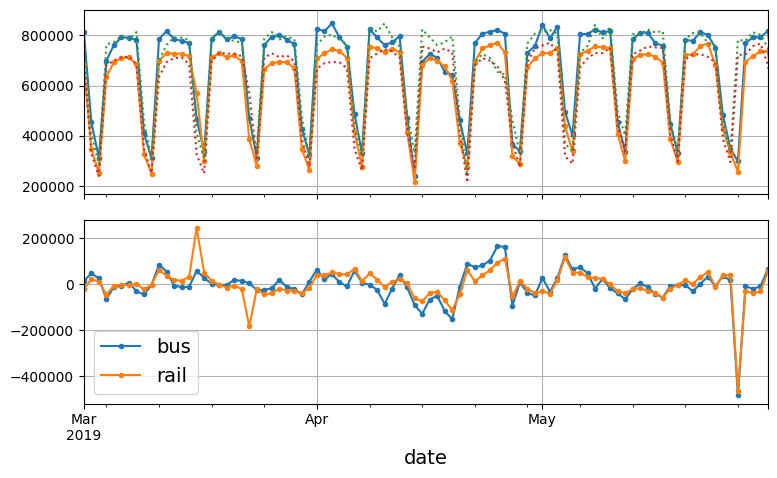

In [19]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
save_fig("differencing_plot")  # extra code – saves the figure for the book
plt.show()

In [20]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

## Simple prediction
Is the number of travellers on the same day last week, a good estimate of the number of travellers today? Compute the mean absolute error (MAE).

In [21]:
diff_7.abs().mean()

,0
bus,43915.608696
rail,42143.271739


Mean absolute percentage error (MAPE):

In [22]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

,0
bus,0.082938
rail,0.089948


Now let's look at the yearly seasonality and the long-term trends:

(**Warning**: Pandas' API to compute the mean for each month has changed quite a bit, so the code below tries the newest API, and falls back to an older API, and if that also fails, it falls back to the code in the book.)

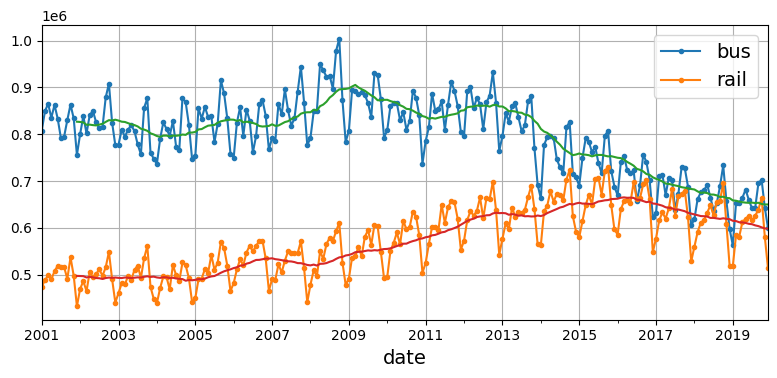

In [23]:
period = slice("2001", "2019")
try:
    df_monthly = df.select_dtypes(include="number").resample('ME').mean()  # compute the mean for each month
    rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()
except ValueError as ex:
    try:
        df_monthly = df.select_dtypes(include="number").resample('M').mean()  # compute the mean for each month
        rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()
    except ValueError as ex:
        df_monthly = df.resample('M').mean()  # compute the mean for each month
        rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
save_fig("long_term_ridership_plot")  # extra code – saves the figure for the book
plt.show()

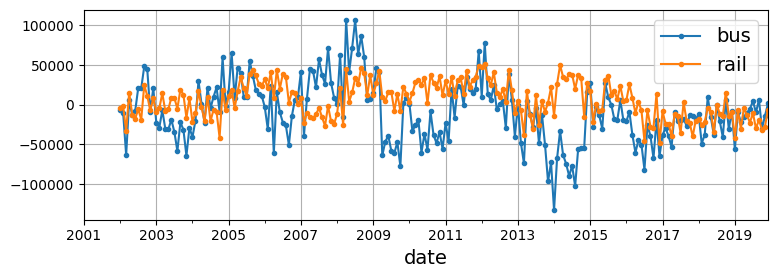

In [24]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
save_fig("yearly_diff_plot")  # extra code – saves the figure for the book
plt.show()

## Optional: Build an ARIMA model

Install the statsmodels library:

In [25]:
!pip install -q -U statsmodels

In [26]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [27]:
y_pred[0]  # ARIMA forecast

<ipython-input-27-0c8da231e770>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred[0]  # ARIMA forecast


427758.62641035335

In [28]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [29]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

Compute the mean average error for the ARIMA model:

In [30]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast().iloc[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

<ipython-input-31-f0ae2b47929d>:4: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(y_preds, color="r", marker=".", label="ARIMA Forecasts")


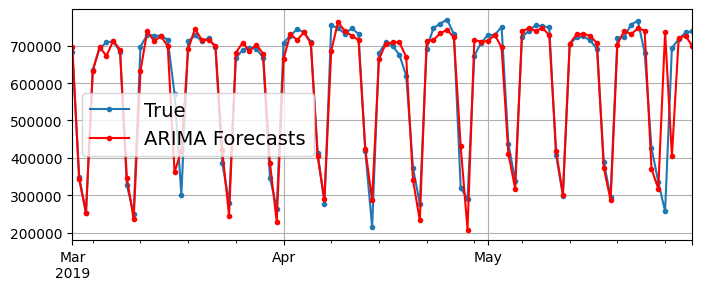

In [31]:
# extra code – displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="ARIMA Forecasts")
plt.legend()
plt.show()

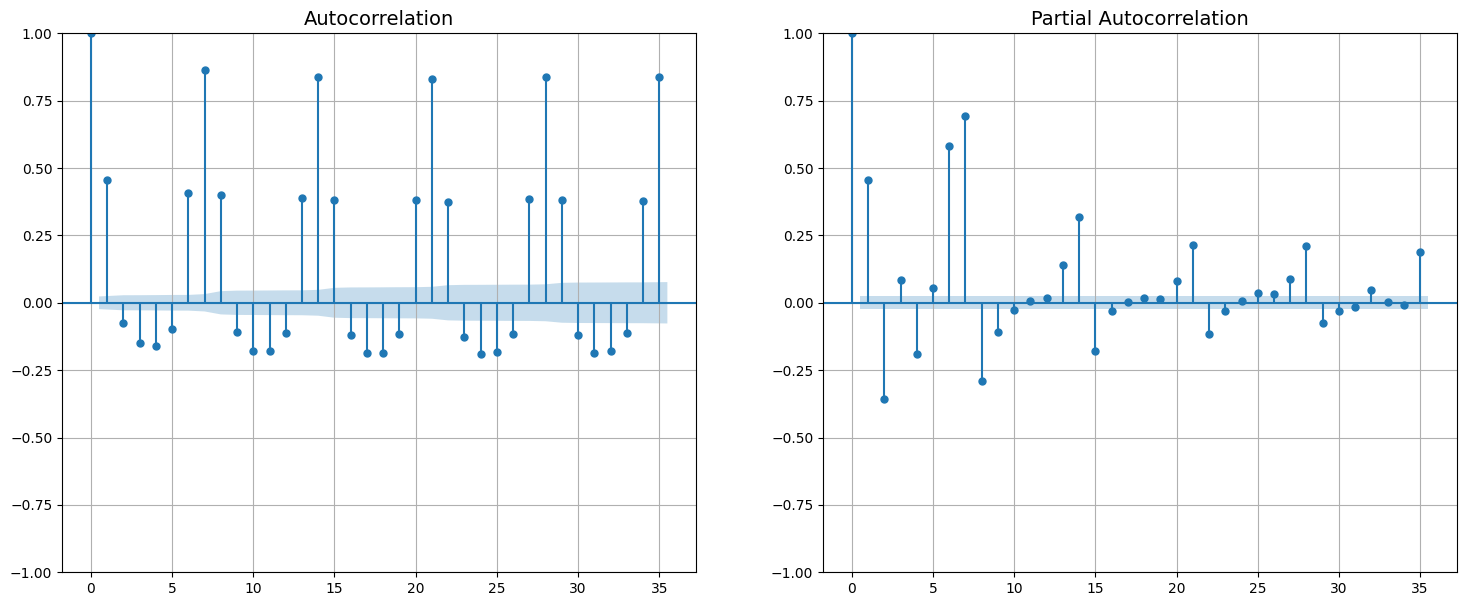

In [32]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

## Using `tf.data.Dataset` with time series

Once we have the data loaded as a NumPy array, we can convert it into a batched TensorFlow dataset using the `timeseries_dataset_from_array` utility function.

In [33]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [34]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [35]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [36]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [37]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [38]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [39]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

## Train a simple dense network

For our first network, we try a dead simple approach with a single `Dense` layer.

In [40]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1227 - mae: 0.3967 - val_loss: 0.0125 - val_mae: 0.1266
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0145 - mae: 0.1284 - val_loss: 0.0062 - val_mae: 0.0817
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0093 - mae: 0.0995 - val_loss: 0.0054 - val_mae: 0.0747
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - mae: 0.0798 - val_loss: 0.0051 - val_mae: 0.0732
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - mae: 0.0832 - val_loss: 0.0048 - val_mae: 0.0701
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - mae: 0.0759 - val_loss: 0.0045 - val_mae: 0.0674
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - mae: 0.0769 - val_loss: 0.0050 - val_mae: 0.0734
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mae: 0.0751 - val_loss: 0.0046 - val_mae: 0.0686
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - mae: 0

Evaluate the prediction preformance:

In [41]:
valid_loss, valid_mae = model.evaluate(valid_ds, verbose=0)
print('Validation MAE:', valid_mae * 1e6)

Validation MAE: 37421.17062211037


## Train a simple RNN

In [42]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
# extra code – defines a utility function we'll reuse several times

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae",
        patience=50,
        restore_best_weights=True
    )
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=opt,
        metrics=["mae"]
    )

    history = model.fit(
        train_set,
        validation_data=valid_set,
        epochs=epochs,
        callbacks=[early_stopping_cb]
    )
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [44]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.4271 - mae: 0.7707 - val_loss: 0.0698 - val_mae: 0.3302
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0592 - mae: 0.2931 - val_loss: 0.0377 - val_mae: 0.2129
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0258 - mae: 0.1627 - val_loss: 0.0152 - val_mae: 0.1478
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0158 - mae: 0.1607 - val_loss: 0.0154 - val_mae: 0.1357
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0152 - mae: 0.1517 - val_loss: 0.0150 - val_mae: 0.1374
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0154 - mae: 0.1551 - val_loss: 0.0148 - val_mae: 0.1360
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0150 - mae: 0.1541 - val_loss: 0.0145 - val_mae: 0.1361
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0147 - mae: 0.1519 - val_loss: 0.0143 - val_mae: 0.1369
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - lo

102826.75921916962

Define the simple RNN network

In [45]:
tf.random.set_seed(42)
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [46]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0232 - mae: 0.1674 - val_loss: 0.0039 - val_mae: 0.0717
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0054 - mae: 0.0782 - val_loss: 0.0033 - val_mae: 0.0649
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0045 - mae: 0.0695 - val_loss: 0.0030 - val_mae: 0.0603
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0049 - mae: 0.0697 - val_loss: 0.0029 - val_mae: 0.0574
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0047 - mae: 0.0662 - val_loss: 0.0034 - val_mae: 0.0608
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0038 - mae: 0.0625 - val_loss: 0.0027 - val_mae: 0.0547
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0040 - mae: 0.0593 - val_loss: 0.0036 - val_mae: 0.0620
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0039 - mae: 0.0606 - val_loss: 0.0030 - val_mae: 0.0517
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - lo

30146.803706884384

## Train a deep RNN

### <span style="color: red; font-weight: bold;">Exercise:<span>

This model won't run, because we have forgotten some arguments to the stacked `SimpleRNN` layers. Fix them, and run the model.

In [67]:
tf.random.set_seed(42)
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32,return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [68]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0234 - mae: 0.1676 - val_loss: 0.0058 - val_mae: 0.0845
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0058 - mae: 0.0758 - val_loss: 0.0038 - val_mae: 0.0656
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0049 - mae: 0.0706 - val_loss: 0.0023 - val_mae: 0.0468
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0045 - mae: 0.0633 - val_loss: 0.0023 - val_mae: 0.0444
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0040 - mae: 0.0626 - val_loss: 0.0021 - val_mae: 0.0406
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0046 - mae: 0.0656 - val_loss: 0.0021 - val_mae: 0.0384
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0043 - mae: 0.0612 - val_loss: 0.0022 - val_mae: 0.0394
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0037 - mae: 0.0546 - val_loss: 0.0027 - val_mae: 0.0490
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - lo

30178.42210829258

## Multivariate time series

Since we have additional observables in the dataset, we can add those to out model too, and se if the results improve:

In [69]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar, dtype=float)  # one-hot encode the day type

In [73]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [74]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

### <span style="color: red; font-weight: bold;">Exercise:<span>

Implement a single-layer RNNs as before, which now has the correct input shape to match the new dataset.

In [76]:
tf.random.set_seed(42)

mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [77]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1448 - mae: 0.3938 - val_loss: 0.0014 - val_mae: 0.0423
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0033 - mae: 0.0629 - val_loss: 0.0017 - val_mae: 0.0487
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0019 - mae: 0.0441 - val_loss: 6.4317e-04 - val_mae: 0.0265
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - mae: 0.0384 - val_loss: 7.6691e-04 - val_mae: 0.0297
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013 - mae: 0.0355 - val_loss: 8.1608e-04 - val_mae: 0.0305
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016 - mae: 0.0405 - val_loss: 6.5811e-04 - val_mae: 0.0271
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012 - mae: 0.0353 - val_loss: 9.3265e-04 - val_mae: 0.0329
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - mae: 0.0385 - val_loss: 6.9672e-04 - val_mae: 0.0267
Epoch 9/500
33/33 ━━━━━━━━━━━━━━

23843.344300985336

### Adding targets to our dataset

Now we try and predict both the number of rail passengers and bus passengers at the same time.

In [78]:
tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

### <span style="color: red; font-weight: bold;">Exercise:<span>

Again make a simple RNN network, which now can predict two outputs.

In [79]:
tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.1882 - mae: 0.4618 - val_loss: 0.0176 - val_mae: 0.1754
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0073 - mae: 0.0934 - val_loss: 0.0027 - val_mae: 0.0607
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0030 - mae: 0.0559 - val_loss: 0.0034 - val_mae: 0.0701
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0026 - mae: 0.0527 - val_loss: 0.0015 - val_mae: 0.0440
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0025 - mae: 0.0510 - val_loss: 0.0013 - val_mae: 0.0420
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0022 - mae: 0.0493 - val_loss: 0.0018 - val_mae: 0.0484
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0022 - mae: 0.0490 - val_loss: 0.0014 - val_mae: 0.0433
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0020 - mae: 0.0471 - val_loss: 0.0018 - val_mae: 0.0484
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0018 -

37763.47637176514

## Forecasting Several Steps Ahead

In [85]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


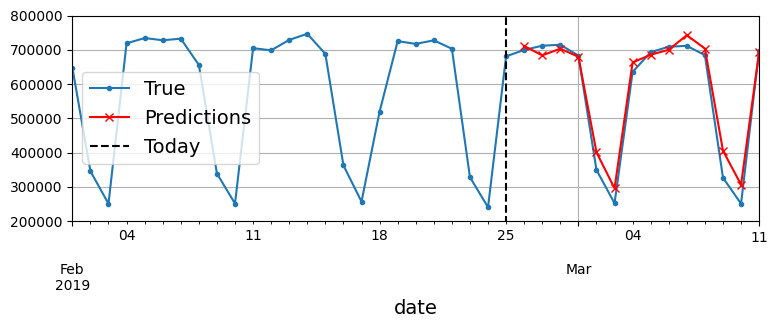

In [90]:
# extra code – generates and saves Figure 15–11

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()

Now let's create an RNN that predicts all 14 next values at once:

In [91]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [92]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [93]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1535 - mae: 0.4321 - val_loss: 0.0243 - val_mae: 0.1630
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0198 - mae: 0.1592 - val_loss: 0.0141 - val_mae: 0.1295
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0136 - mae: 0.1304 - val_loss: 0.0100 - val_mae: 0.1090
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0112 - mae: 0.1189 - val_loss: 0.0083 - val_mae: 0.1000
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0095 - mae: 0.1074 - val_loss: 0.0068 - val_mae: 0.0904
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0084 - mae: 0.0997 - val_loss: 0.0059 - val_mae: 0.0840
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0075 - mae: 0.0925 - val_loss: 0.0048 - val_mae: 0.0769
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - mae: 0.0856 - val_loss: 0.0045 - val_mae: 0.0742
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - lo

33442.1843290329

In [94]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Now let's create an RNN that predicts the next 14 steps at each time step. That is, instead of just forecasting time steps 56 to 69 based on time steps 0 to 55, it will forecast time steps 1 to 14 at time step 0, then time steps 2 to 15 at time step 1, and so on, and finally it will forecast time steps 56 to 69 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

To prepare the datasets, we can use `to_windows()` twice, to get sequences of consecutive windows, like this:

In [95]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

Then we can split these elements into the desired inputs and targets:

In [96]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

Let's wrap this idea into a utility function. It will also take care of shuffling (optional) and batching:

In [97]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(
        lambda S: (S[:, 0], S[:, 1:, target_col]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [98]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [99]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [100]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
     30/Unknown 2s 17ms/step - loss: 0.1861 - mae: 0.4704

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1746 - mae: 0.4510 - val_loss: 0.0189 - val_mae: 0.1437
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0129 - mae: 0.1235 - val_loss: 0.0089 - val_mae: 0.0983
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0078 - mae: 0.0919 - val_loss: 0.0064 - val_mae: 0.0786
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0061 - mae: 0.0784 - val_loss: 0.0058 - val_mae: 0.0734
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0052 - mae: 0.0696 - val_loss: 0.0052 - val_mae: 0.0678
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0047 - mae: 0.0654 - val_loss: 0.0046 - val_mae: 0.0620
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0045 - mae: 0.0638 - val_loss: 0.0048 - val_mae: 0.0650
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0044 - mae: 0.0615 - val_loss: 0.0046 - val_mae: 0.0618
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0042 -

47849.45026040077

In [101]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step


In [102]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

      1/Unknown 0s 176ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
MAE for +1: 24,254
MAE for +2: 29,062
MAE for +3: 30,298
MAE for +4: 34,340
MAE for +5: 33,491
MAE for +6: 36,926
MAE for +7: 35,125
MAE for +8: 35,299
MAE for +9: 35,250
MAE for +10: 31,788
MAE for +11: 35,895
MAE for +12: 36,254
MAE for +13: 36,630
MAE for +14: 33,296


## Adding layer normalisation

To add layer normalisation (`keras.layers.LayerNormalization`), we should put it in between the RNN layer and the activation function.

The book does this in a somewhat fancy way, by subclassing the generic Keras `Layer` and making a custom one.

In [103]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [104]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Just training for 5 epochs to show that it works (you can increase this if you want):

In [105]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - loss: 0.1252 - mae: 0.3702 - val_loss: 0.0175 - val_mae: 0.1486
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0154 - mae: 0.1449 - val_loss: 0.0154 - val_mae: 0.1255
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0125 - mae: 0.1297 - val_loss: 0.0146 - val_mae: 0.1200
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0115 - mae: 0.1212 - val_loss: 0.0132 - val_mae: 0.1147
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0106 - mae: 0.1155 - val_loss: 0.0122 - val_mae: 0.1096
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0132 - mae: 0.1134


109612.79273033142

## Train an LSTM network

In [106]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [107]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0868 - mae: 0.3357 - val_loss: 0.0184 - val_mae: 0.1636
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0174 - mae: 0.1586 - val_loss: 0.0168 - val_mae: 0.1431
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0152 - mae: 0.1477 - val_loss: 0.0160 - val_mae: 0.1373
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0143 - mae: 0.1423 - val_loss: 0.0152 - val_mae: 0.1339
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0135 - mae: 0.1377 - val_loss: 0.0145 - val_mae: 0.1307
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0153 - mae: 0.1332


130737.34939098358

## Train a GRU network

In [108]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [109]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1051 - mae: 0.3735 - val_loss: 0.0169 - val_mae: 0.1489
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0151 - mae: 0.1401 - val_loss: 0.0141 - val_mae: 0.1314
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0123 - mae: 0.1270 - val_loss: 0.0130 - val_mae: 0.1255
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0113 - mae: 0.1218 - val_loss: 0.0123 - val_mae: 0.1222
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0107 - mae: 0.1180 - val_loss: 0.0118 - val_mae: 0.1194
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0126 - mae: 0.1227


119404.50221300125

## Using One-Dimensional Convolutional Layers to Process Sequences

```
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

In [110]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Just training for 5 epochs to show that it works (you can increase this if you want):

In [111]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
     30/Unknown 4s 38ms/step - loss: 0.1157 - mae: 0.3944

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.1122 - mae: 0.3864 - val_loss: 0.0212 - val_mae: 0.1532
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0169 - mae: 0.1548 - val_loss: 0.0165 - val_mae: 0.1382
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0140 - mae: 0.1422 - val_loss: 0.0152 - val_mae: 0.1295
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0125 - mae: 0.1324 - val_loss: 0.0138 - val_mae: 0.1217
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0112 - mae: 0.1229 - val_loss: 0.0124 - val_mae: 0.1148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0124 - mae: 0.1148


114830.46412467957